# Previsão de renda

### 4 elementos importantes
- Esse notebook
- Streamlit com as análises
- Seu Github com o projeto
- Vídeo no readme do github mostrando o streamlit

In [ ]:
!pip install ydata-profiling
!pip install ipywidgets jupyterlab_widgets
!pip install -U ydata-sdk
!pip install -U ydata-profiling[notebook,unicode,pyspark]

## Etapa 1 CRISP - DM: Entendimento do negócio

Objetivo:

Prever a renda mensal de clientes com base em dados socioeconômicos e demográficos.
Avaliar capacidade de crédito
Definir limites de cartão ou empréstimo
Reduzir inadimplência
Segmentação e marketing direcionado

Questão:

Quais variáveis influenciam mais a renda?
É possível prever renda de forma confiável sem dados sensíveis?
O modelo pode melhorar a política de concessão de crédito?

## Etapa 2 Crisp-DM: Entendimento dos dados

#### Carregando os pacotes

In [3]:
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import scipy.stats as stats

import joblib
import pickle


#### Carregando os dados

In [11]:
df = pd.read_csv('./input/previsao_de_renda.csv')

In [12]:
df.head(10)

Unnamed: 0    data_ref  id_cliente sexo  posse_de_veiculo  posse_de_imovel  \
0           0  2015-01-01       15056    F             False             True   
1           1  2015-01-01        9968    M              True             True   
2           2  2015-01-01        4312    F              True             True   
3           3  2015-01-01       10639    F             False             True   
4           4  2015-01-01        7064    M              True            False   
5           5  2015-01-01       10581    F             False             True   
6           6  2015-01-01        7129    F             False             True   
7           7  2015-01-01        9952    F             False             True   
8           8  2015-01-01         883    F             False             True   
9           9  2015-01-01        8070    M              True             True   

   qtd_filhos        tipo_renda           educacao estado_civil  \
0           0        Empresário         Secundário     Solteiro   
1           0       Assalariado  Superior completo       Casado   
2           0        Empresário  Superior completo       Casado   
3           1  Servidor público  Superior completo       Casado   
4           0       Assalariado         Secundário     Solteiro   
5           0       Assalariado  Superior completo       Casado   
6           0        Empresário  Superior completo        Viúvo   
7           0        Empresário         Secundário       Casado   
8           0       Assalariado         Secundário       Casado   
9           0       Assalariado  Superior completo       Casado   

  tipo_residencia  idade  tempo_emprego  qt_pessoas_residencia     renda  
0            Casa     26       6.602740                    1.0   8060.34  
1            Casa     28       7.183562                    2.0   1852.15  
2            Casa     35       0.838356                    2.0   2253.89  
3            Casa     30       4.846575                    3.0   6600.77  
4   Governamental     33       4.293151                    1.0   6475.97  
5            Casa     39       4.345205                    2.0   1445.87  
6            Casa     55       6.378082                    1.0   1726.03  
7            Casa     36       3.104110                    2.0   2515.98  
8            Casa     50      18.605479                    2.0   3420.34  
9            Casa     60      10.558904                    2.0  12939.14

In [13]:
# variável, descrição e tipo


# Criar dicionário de dados
dicionario = {
    "data_ref": [
        "Data de referência da coleta da informação do cliente.",
        str(df["data_ref"].dtype)
    ],
    "id_cliente": [
        "Identificador único do cliente.",
        str(df["id_cliente"].dtype)
    ],
    "sexo": [
        "Sexo do cliente (Masculino/Feminino).",
        str(df["sexo"].dtype)
    ],
    "posse_de_veiculo": [
        "Indica se o cliente possui veículo (Sim/Não).",
        str(df["posse_de_veiculo"].dtype)
    ],
    "posse_de_imovel": [
        "Indica se o cliente possui imóvel (Sim/Não).",
        str(df["posse_de_imovel"].dtype)
    ],
    "qtd_filhos": [
        "Quantidade de filhos do cliente.",
        str(df["qtd_filhos"].dtype)
    ],
    "tipo_renda": [
        "Fonte principal de renda do cliente (ex.: Assalariado, Empresário etc.).",
        str(df["tipo_renda"].dtype)
    ],
    "educacao": [
        "Nível de escolaridade do cliente.",
        str(df["educacao"].dtype)
    ],
    "estado_civil": [
        "Estado civil do cliente.",
        str(df["estado_civil"].dtype)
    ],
    "tipo_residencia": [
        "Tipo de residência em que o cliente vive.",
        str(df["tipo_residencia"].dtype)
    ],
    "idade": [
        "Idade do cliente em anos.",
        str(df["idade"].dtype)
    ],
    "tempo_emprego": [
        "Tempo de emprego atual do cliente (em anos, podendo conter valores nulos).",
        str(df["tempo_emprego"].dtype)
    ],
    "qt_pessoas_residencia": [
        "Quantidade de pessoas que moram na residência do cliente.",
        str(df["qt_pessoas_residencia"].dtype)
    ],
    "renda": [
        "Renda mensal declarada pelo cliente.",
        str(df["renda"].dtype)
    ]
}

# Converter para DataFrame
dic_df = pd.DataFrame.from_dict(
    dicionario, orient="index", columns=["Descrição", "Tipo"]
).reset_index()

dic_df.rename(columns={"index": "Variável"}, inplace=True)

# Exibir
print(dic_df)

# Se quiser salvar em Excel
dic_df.to_excel("dicionario_de_dados.xlsx", index=False)

# Ou em CSV
dic_df.to_csv("dicionario_de_dados.csv", index=False)


                 Variável                                          Descrição  \
0                data_ref  Data de referência da coleta da informação do ...   
1              id_cliente                    Identificador único do cliente.   
2                    sexo              Sexo do cliente (Masculino/Feminino).   
3        posse_de_veiculo      Indica se o cliente possui veículo (Sim/Não).   
4         posse_de_imovel       Indica se o cliente possui imóvel (Sim/Não).   
5              qtd_filhos                   Quantidade de filhos do cliente.   
6              tipo_renda  Fonte principal de renda do cliente (ex.: Assa...   
7                educacao                  Nível de escolaridade do cliente.   
8            estado_civil                           Estado civil do cliente.   
9         tipo_residencia          Tipo de residência em que o cliente vive.   
10                  idade                          Idade do cliente em anos.   
11          tempo_emprego  Tempo de empr

In [14]:
# Primeiras linhas do dataset, descrição das variáveis e tipos


# Mostrar primeiras linhas para contexto
print("📌 Primeiras linhas do dataset:")
print(df.head(), "\n")

# Descrição das variáveis
print("📌 Descrição das variáveis e tipos:\n")
for col in df.columns:
    print(f"Coluna: {col}")
    print(f"  Tipo de dado: {df[col].dtype}")
    print(f"  Valores únicos: {df[col].nunique()}")
    print(f"  Valores ausentes: {df[col].isna().sum()}")
    
    if pd.api.types.is_numeric_dtype(df[col]):
        print(f"  Média: {df[col].mean():.2f}")
        print(f"  Desvio padrão: {df[col].std():.2f}")
        print(f"  Mínimo: {df[col].min()}")
        print(f"  Máximo: {df[col].max()}")
    else:
        print(f"  Principais categorias: {df[col].value_counts().head(5).to_dict()}")
    print("-"*50)


📌 Primeiras linhas do dataset:
   Unnamed: 0    data_ref  id_cliente sexo  posse_de_veiculo  posse_de_imovel  \
0           0  2015-01-01       15056    F             False             True   
1           1  2015-01-01        9968    M              True             True   
2           2  2015-01-01        4312    F              True             True   
3           3  2015-01-01       10639    F             False             True   
4           4  2015-01-01        7064    M              True            False   

   qtd_filhos        tipo_renda           educacao estado_civil  \
0           0        Empresário         Secundário     Solteiro   
1           0       Assalariado  Superior completo       Casado   
2           0        Empresário  Superior completo       Casado   
3           1  Servidor público  Superior completo       Casado   
4           0       Assalariado         Secundário     Solteiro   

  tipo_residencia  idade  tempo_emprego  qt_pessoas_residencia    renda  
0    

In [15]:
# Relatório Profiling

# Criar relatório
profile = ProfileReport(
    df, 
    title="Relatório de Profiling - Previsão de Renda", 
    explorative=True
)

profile.to_notebook_iframe()

# Salvar em HTML
profile.to_file("relatorio_profiling.html")

print("✅ Relatório salvo como 'relatorio_profiling.html'.")
print("Abra o arquivo no navegador para visualizar.")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 15/15 [00:03<00:00,  4.98it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Relatório salvo como 'relatorio_profiling.html'.
Abra o arquivo no navegador para visualizar.


#### Entendimento dos dados - Univariada


📌 Estatísticas descritivas:
         sexo posse_de_veiculo posse_de_imovel  qtd_filhos   tipo_renda  \
count   15000            15000           15000    15000.00        15000   
unique      2                2               2         NaN            5   
top         F            False            True         NaN  Assalariado   
freq    10119             9140           10143         NaN         7633   
mean      NaN              NaN             NaN        0.43          NaN   
std       NaN              NaN             NaN        0.75          NaN   
min       NaN              NaN             NaN        0.00          NaN   
25%       NaN              NaN             NaN        0.00          NaN   
50%       NaN              NaN             NaN        0.00          NaN   
75%       NaN              NaN             NaN        1.00          NaN   
max       NaN              NaN             NaN       14.00          NaN   

          educacao estado_civil tipo_residencia     idade  tempo_empre

<Figure size 1000x600 with 0 Axes>

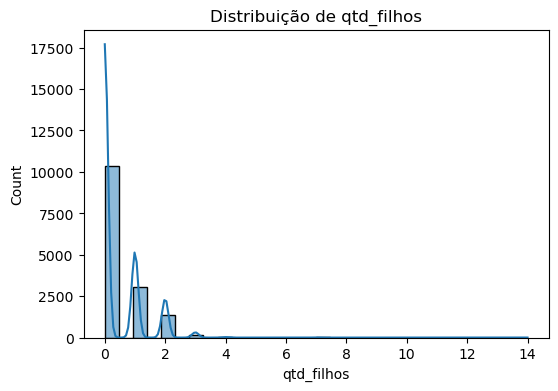

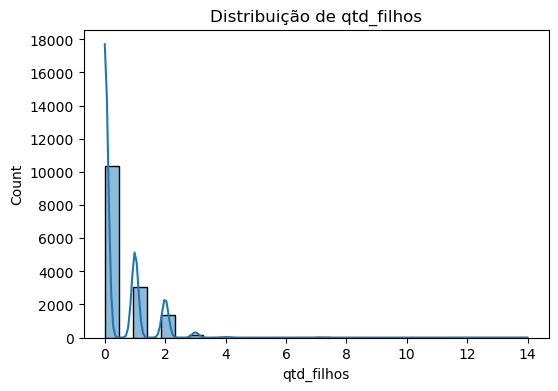

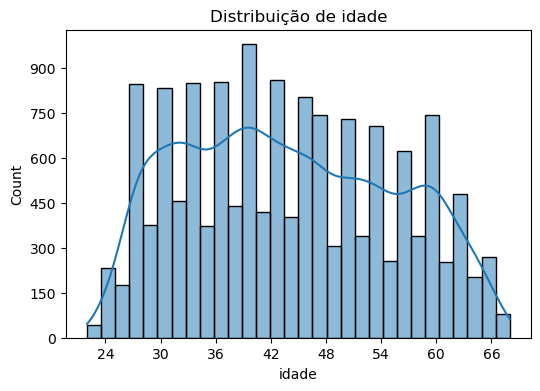

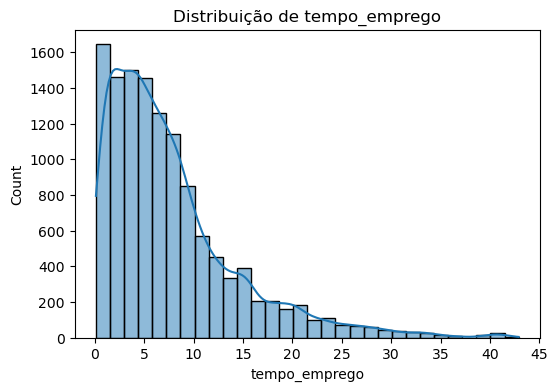

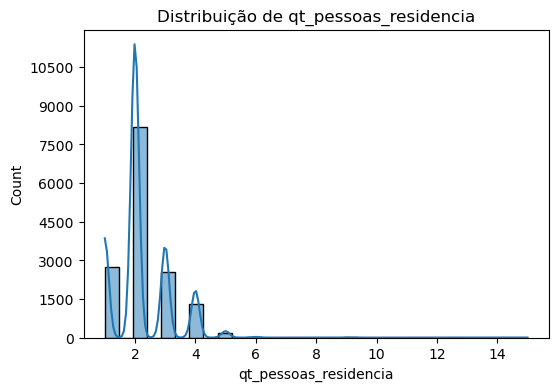

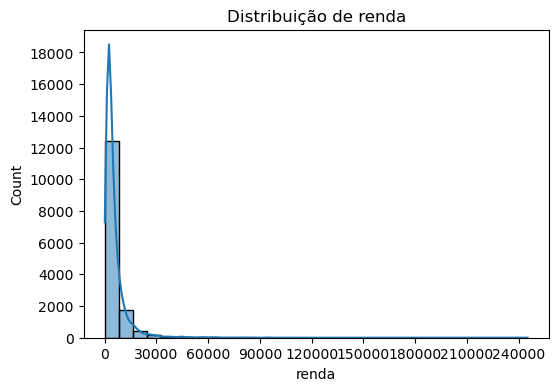

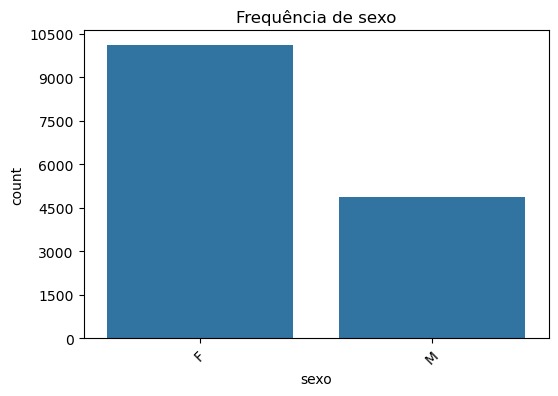

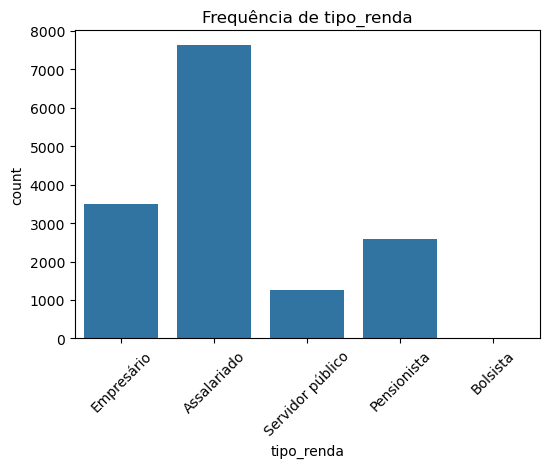

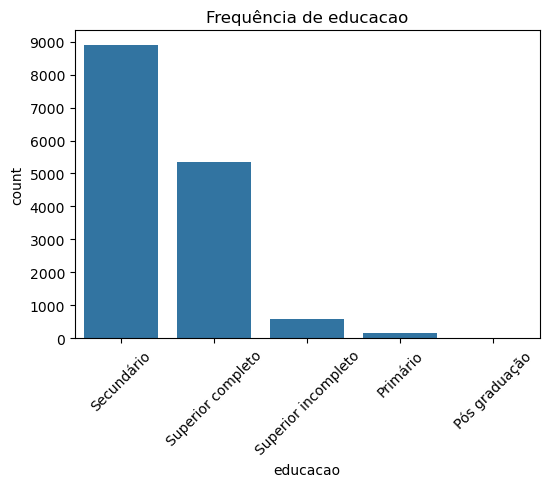

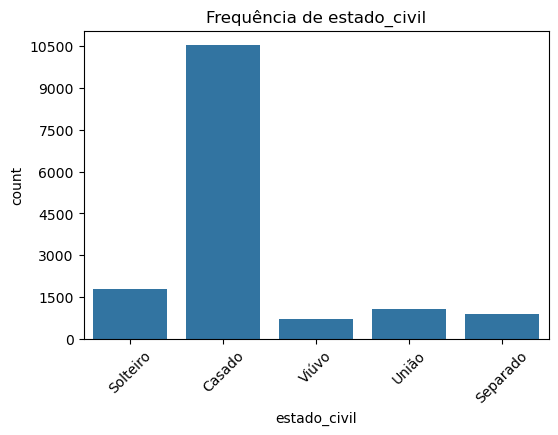

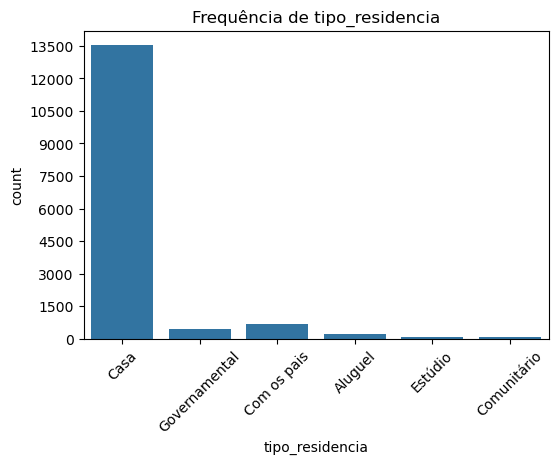

In [19]:
%matplotlib inline

# Lista de colunas para ignorar
ignore_cols = ["Unnamed: 0", "id_cliente", "data_ref"]

# 🔹 Estatísticas descritivas (sem as colunas ignoradas)
print("\n📌 Estatísticas descritivas:")
print(df.drop(columns=ignore_cols, errors="ignore").describe(include="all").round(2))

# Distribuições de variáveis numéricas
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
num_cols = [col for col in num_cols if col not in ignore_cols]

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribuição de {col}")
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()
    plt.close()

# Contagem de variáveis categóricas
cat_cols = df.select_dtypes(include=['object', 'category']).columns
cat_cols = [col for col in cat_cols if col not in ignore_cols]

for col in cat_cols:
    plt.figure(figsize=(6,4))
    if df[col].nunique() > 20:
        top_vals = df[col].value_counts().nlargest(20).index
        sns.countplot(x=df[col][df[col].isin(top_vals)])
        plt.title(f"Frequência de {col} (Top 20)")
    else:
        sns.countplot(x=df[col])
        plt.title(f"Frequência de {col}")

    plt.xticks(rotation=45)
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()
    plt.close()



### Entendimento dos dados - Bivariadas




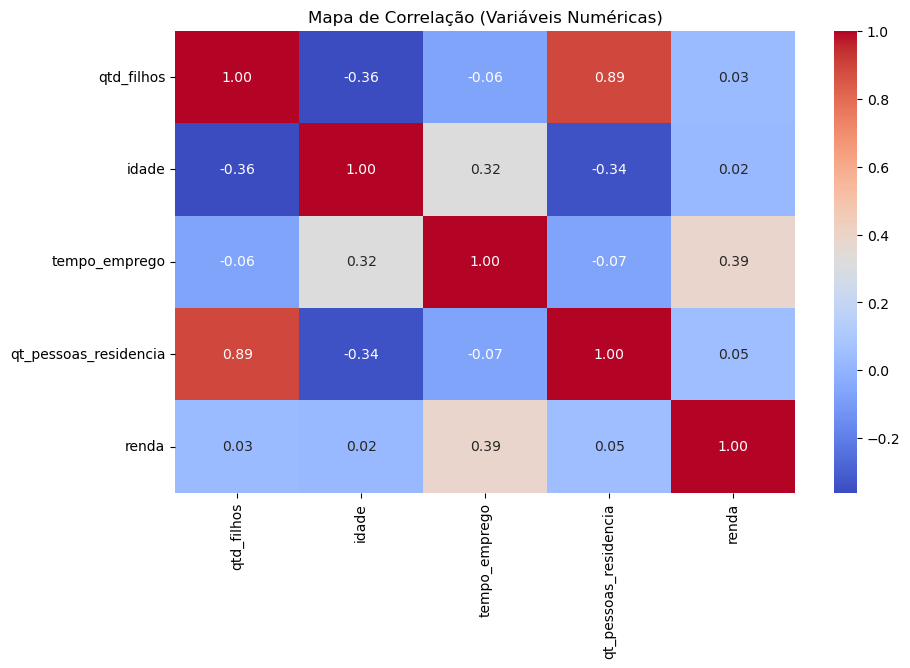

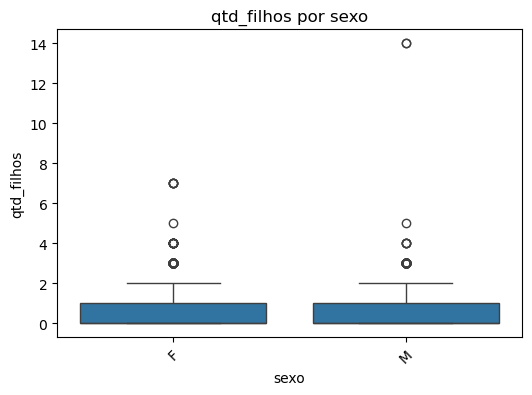

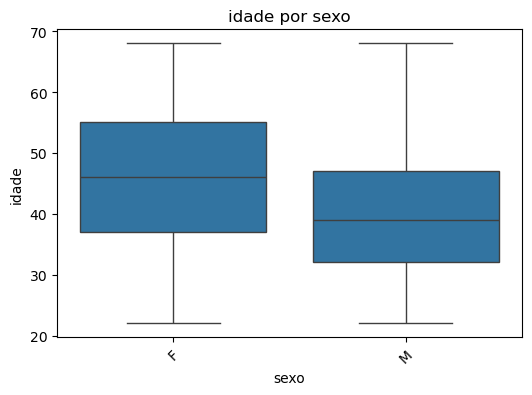

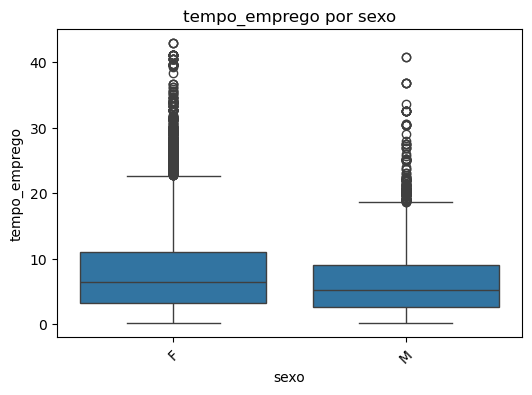

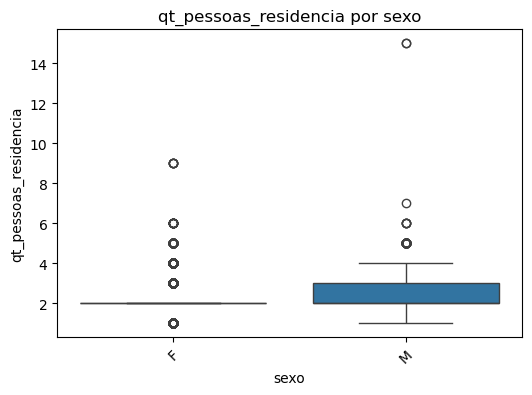

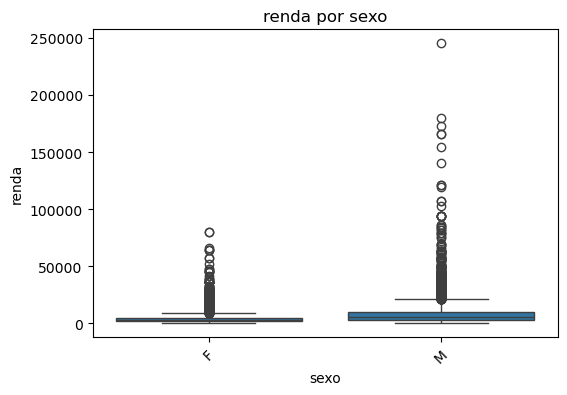

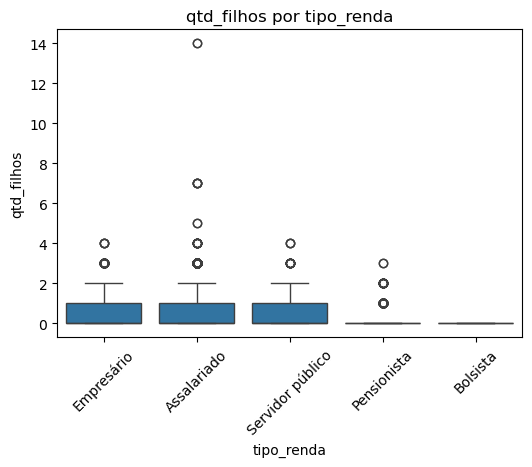

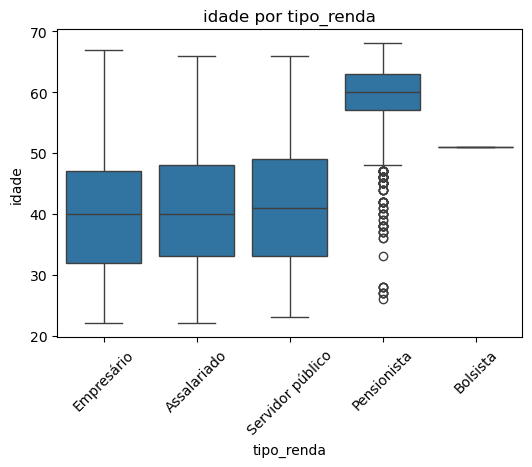

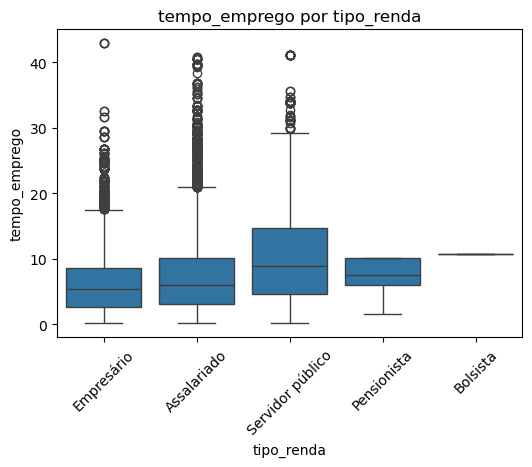

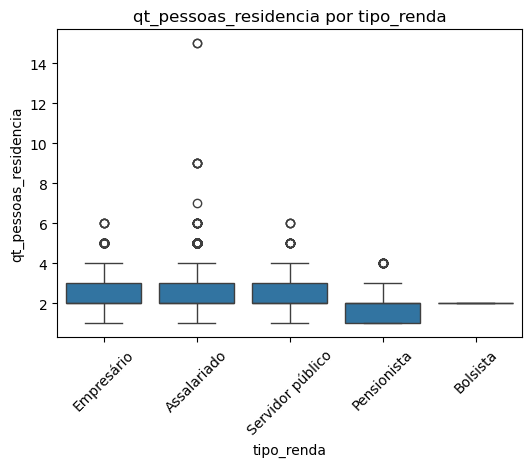

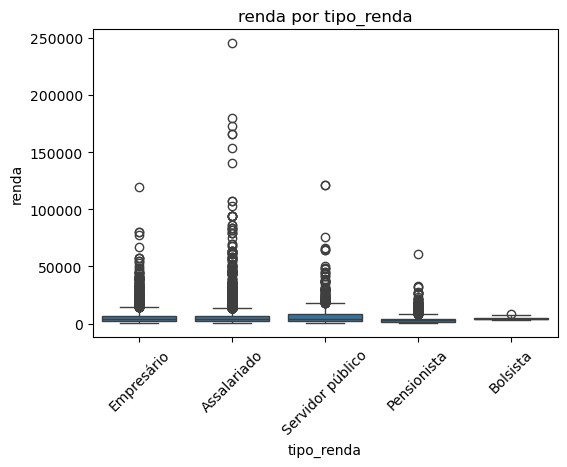

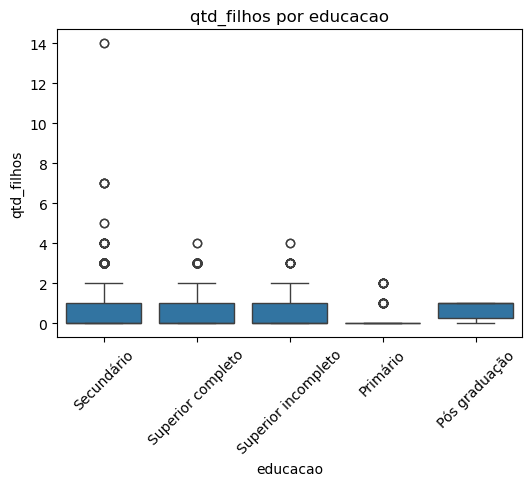

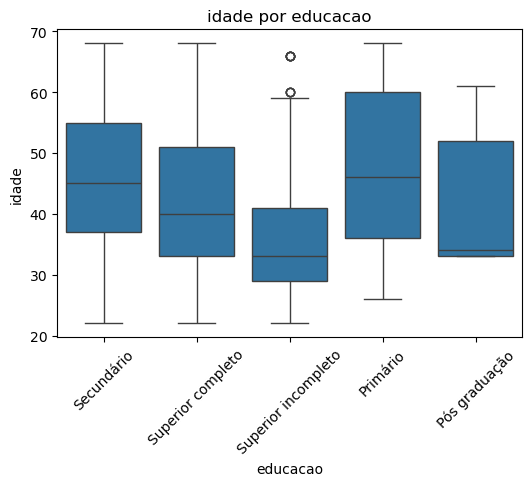

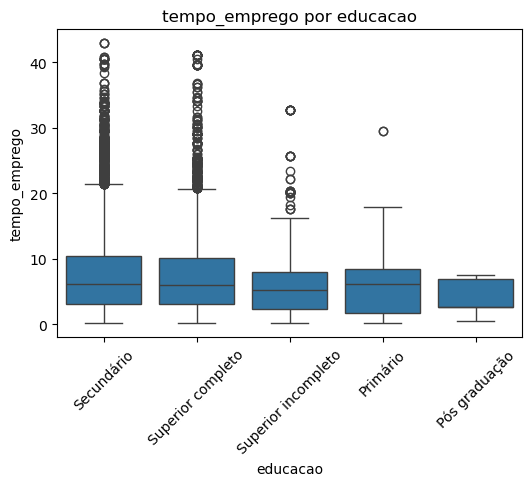

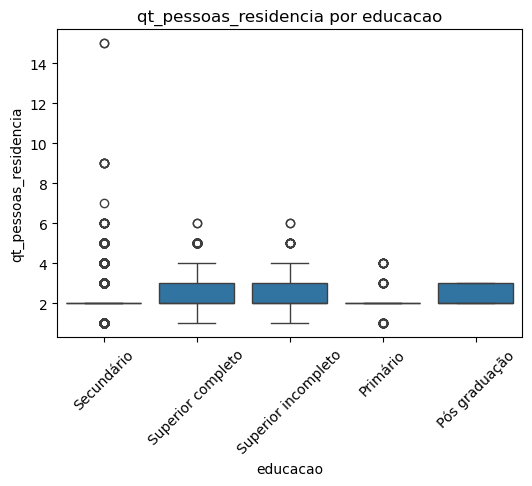

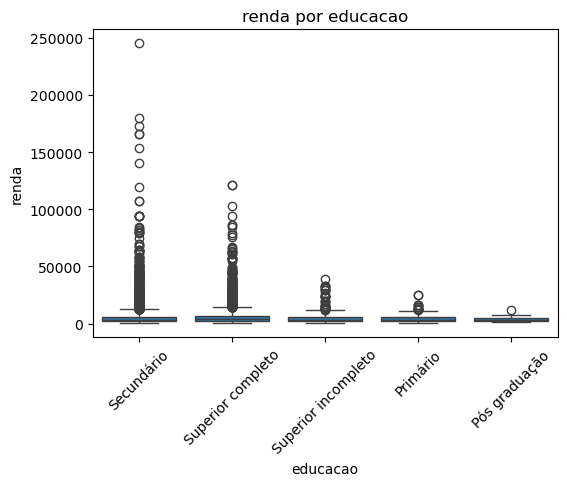

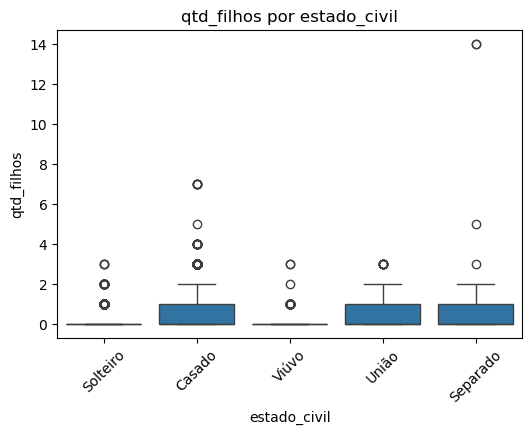

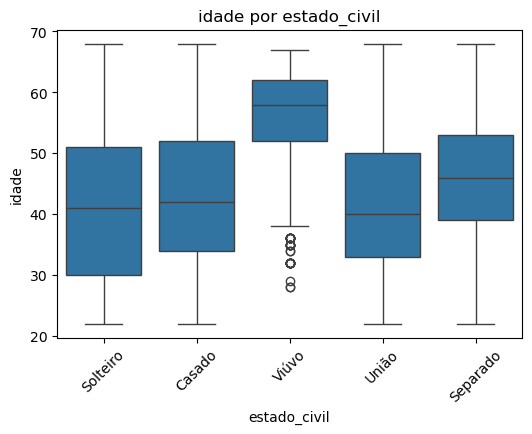

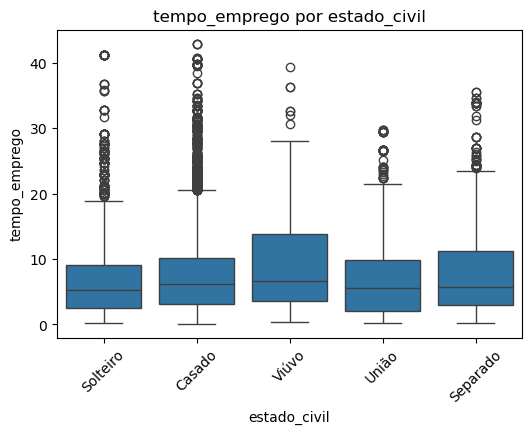

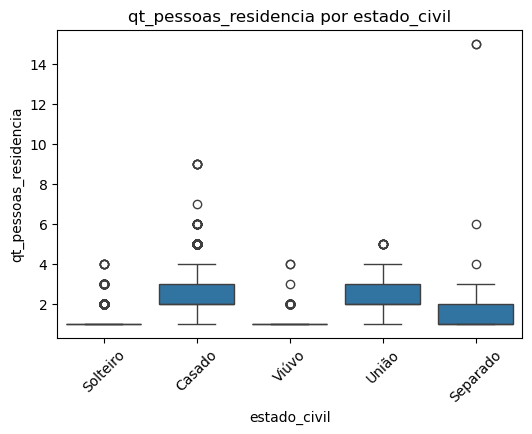

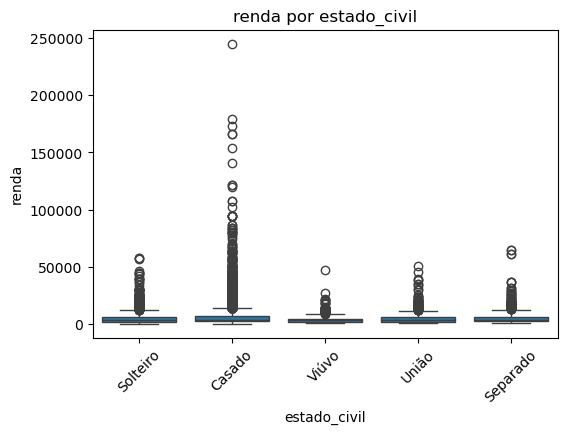

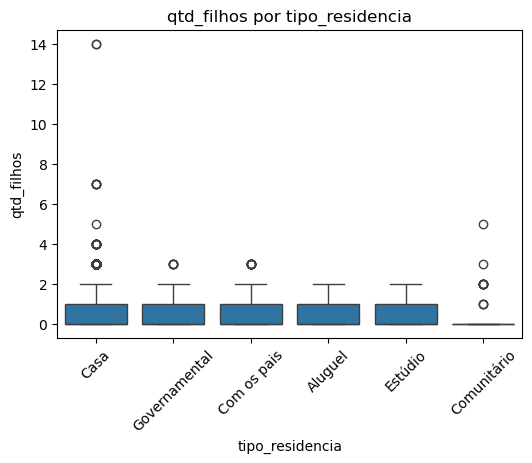

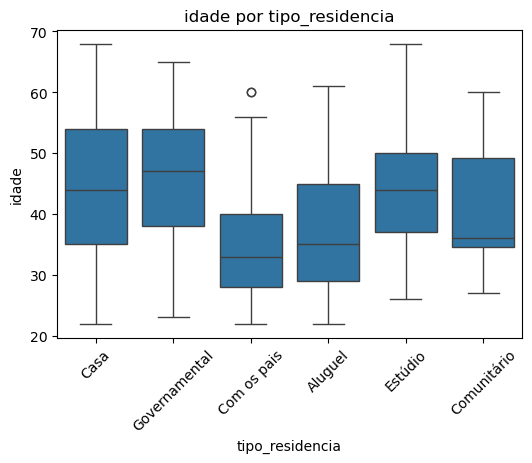

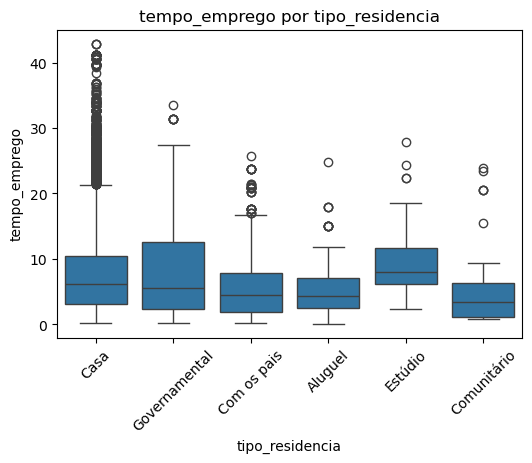

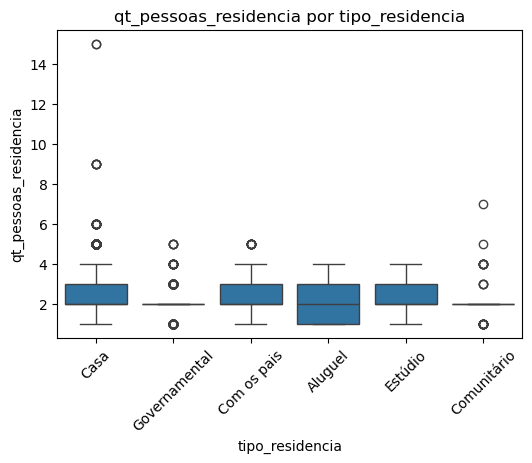

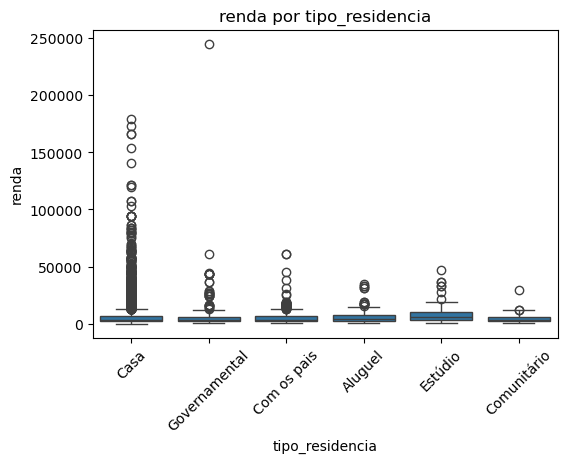

In [21]:
%matplotlib inline

# Distribuições de variáveis numéricas
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
num_cols = [col for col in num_cols if col not in ignore_cols]

# Contagem de variáveis categóricas
cat_cols = df.select_dtypes(include=['object', 'category']).columns
cat_cols = [col for col in cat_cols if col not in ignore_cols]

# Correlação entre variáveis numéricas
plt.figure(figsize=(10,6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Mapa de Correlação (Variáveis Numéricas)")
plt.show()
plt.close()

# Relação entre categóricas e numéricas
for col in cat_cols:
    for num in num_cols:
        plt.figure(figsize=(6,4))
        sns.boxplot(x=df[col], y=df[num])
        plt.title(f"{num} por {col}")
        plt.xticks(rotation=45)
        plt.show()


## Etapa 3 Crisp-DM: Preparação dos dados

 - **seleção**
 - **limpeza**
 - **construção**: construção de novas variáveis
 - **integração**: Temos apenas uma fonte de dados, não é necessário integração
 - **formatação**



In [24]:
def preparar_dados(df):
    return (
        df
        # Remove colunas irrelevantes
        .drop(columns=["Unnamed: 0", "id_cliente", "data_ref"], errors="ignore")
        
        # Trata valores nulos e cria variável log
        .assign(
            tempo_emprego=lambda d: d["tempo_emprego"].fillna(d["tempo_emprego"].median()),
            renda_log=lambda d: np.log1p(d["renda"])
        )
        # Transforma variáveis categóricas em dummies
        .pipe(lambda d: pd.get_dummies(d, drop_first=True))
    )


df_prep = df.pipe(preparar_dados)

df_prep.head(10)

posse_de_veiculo  posse_de_imovel  qtd_filhos  idade  tempo_emprego  \
0             False             True           0     26       6.602740   
1              True             True           0     28       7.183562   
2              True             True           0     35       0.838356   
3             False             True           1     30       4.846575   
4              True            False           0     33       4.293151   
5             False             True           0     39       4.345205   
6             False             True           0     55       6.378082   
7             False             True           0     36       3.104110   
8             False             True           0     50      18.605479   
9              True             True           0     60      10.558904   

   qt_pessoas_residencia     renda  renda_log  sexo_M  tipo_renda_Bolsista  \
0                    1.0   8060.34   8.994835   False                False   
1                    2.0   1852.15   7.524642    True                False   
2                    2.0   2253.89   7.720856   False                False   
3                    3.0   6600.77   8.795093   False                False   
4                    1.0   6475.97   8.776008    True                False   
5                    2.0   1445.87   7.277158   False                False   
6                    1.0   1726.03   7.454158   False                False   
7                    2.0   2515.98   7.830815   False                False   
8                    2.0   3420.34   8.137788   False                False   
9                    2.0  12939.14   9.468089    True                False   

   ...  educacao_Superior incompleto  estado_civil_Separado  \
0  ...                         False                  False   
1  ...                         False                  False   
2  ...                         False                  False   
3  ...                         False                  False   
4  ...                         False                  False   
5  ...                         False                  False   
6  ...                         False                  False   
7  ...                         False                  False   
8  ...                         False                  False   
9  ...                         False                  False   

   estado_civil_Solteiro  estado_civil_União  estado_civil_Viúvo  \
0                   True               False               False   
1                  False               False               False   
2                  False               False               False   
3                  False               False               False   
4                   True               False               False   
5                  False               False               False   
6                  False               False                True   
7                  False               False               False   
8                  False               False               False   
9                  False               False               False   

   tipo_residencia_Casa  tipo_residencia_Com os pais  \
0                  True                        False   
1                  True                        False   
2                  True                        False   
3                  True                        False   
4                 False                        False   
5                  True                        False   
6                  True                        False   
7                  True                        False   
8                  True                        False   
9                  True                        False   

   tipo_residencia_Comunitário  tipo_residencia_Estúdio  \
0                        False                    False   
1                        False                    False   
2                        False                    False   
3                        False   

In [ ]:
## Etapa 4 Crisp-DM: Modelagem

              Modelo        R²         RMSE
0             Linear  0.153962  7603.591310
1        Logarítmico  0.096413  7857.940321
2  Polinomial Grau 2  0.169633  7532.840585


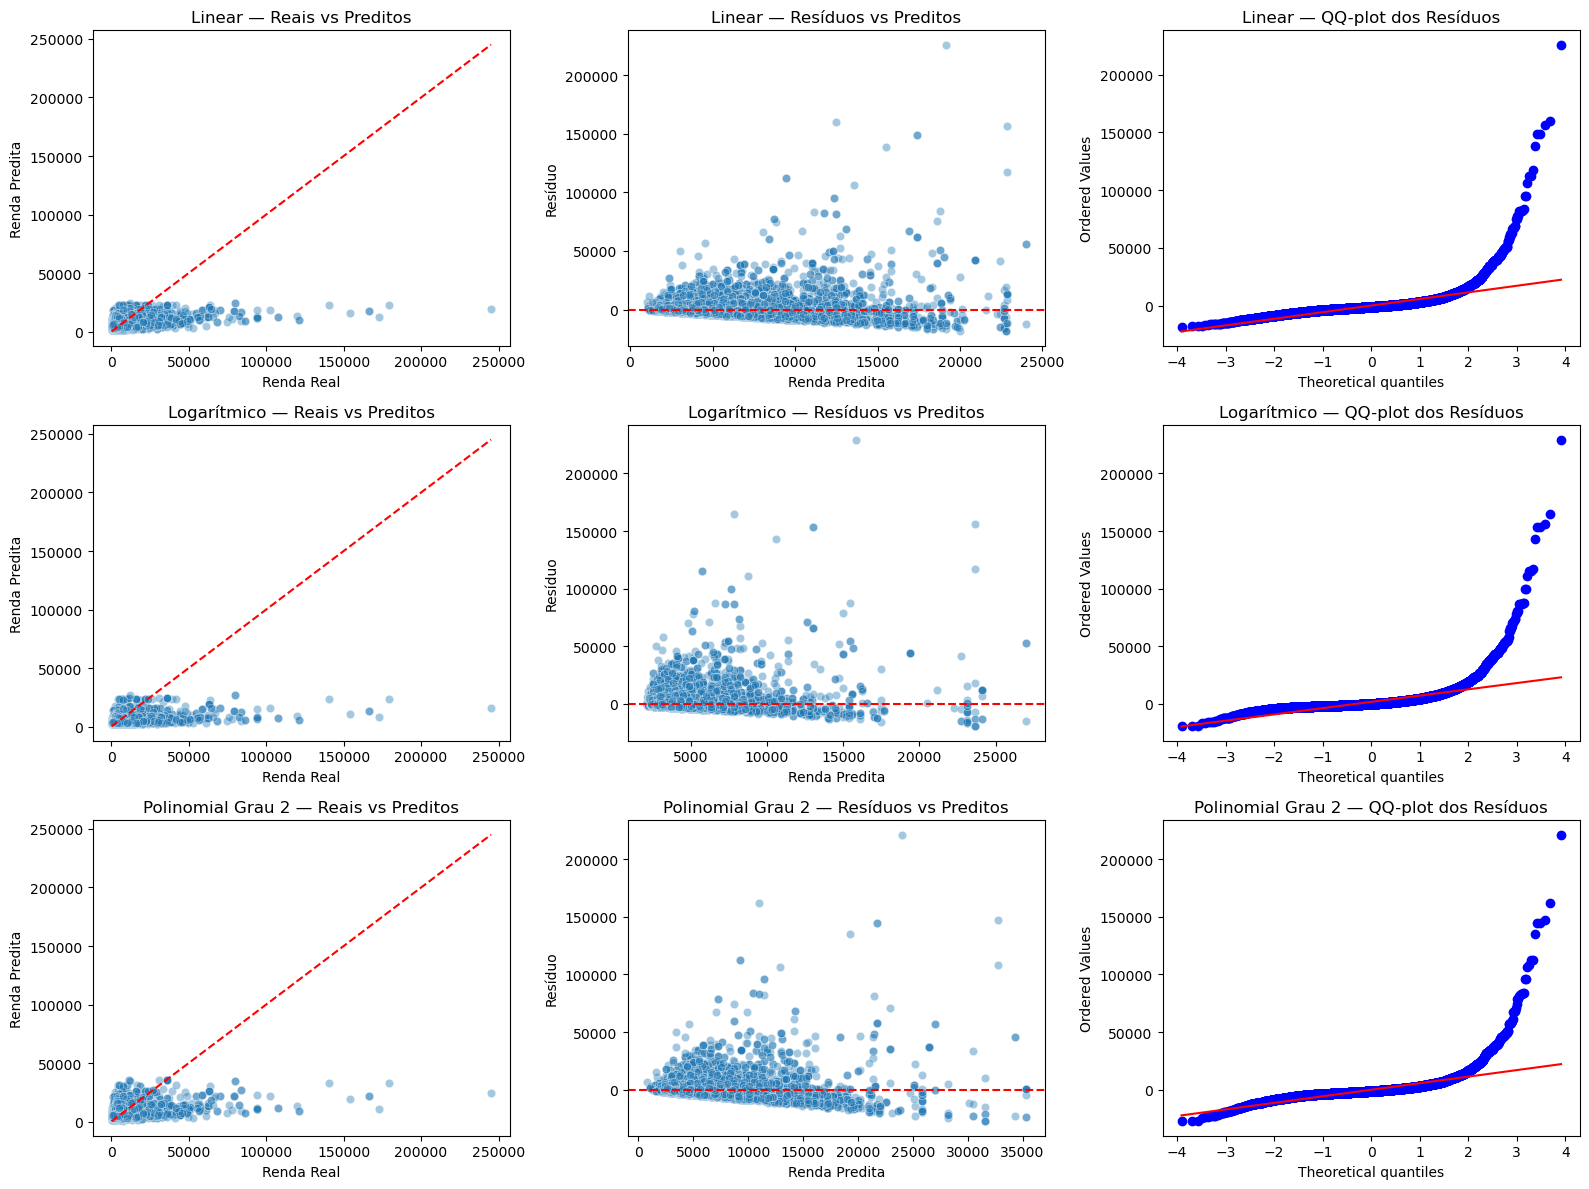

In [25]:
# MODELOS LINEAR, LOGARITÍMICO E POLINOMINAL COM AS TRÊS VARIÁVEIS DE CORRELAÇÃO FORTE COM RENDA

X = df_prep[["tempo_emprego", "idade", "qt_pessoas_residencia"]]
y = df_prep["renda"]


# AJUSTAR MODELOS

# 1) Linear
lin_reg = LinearRegression()
lin_reg.fit(X, y)
y_pred_lin = lin_reg.predict(X)

# 2) Logarítmico (modelo sobre log(1+renda), retorna à escala original)
log_reg = LinearRegression()
log_reg.fit(X, np.log1p(y))
y_pred_log = np.expm1(log_reg.predict(X))  # volta para escala original

# 3) Polinomial grau 2
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
poly_reg = LinearRegression()
poly_reg.fit(X_poly, y)
y_pred_poly = poly_reg.predict(X_poly)


# MÉTRICAS (R² e RMSE)

def calc_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # <-- aqui usamos sqrt(MSE)
    return r2, rmse

res_lin = calc_metrics(y, y_pred_lin)
res_log = calc_metrics(y, y_pred_log)
res_poly = calc_metrics(y, y_pred_poly)


resultados = pd.DataFrame({
    "Modelo": ["Linear", "Logarítmico", "Polinomial Grau 2"],
    "R²": [res_lin[0], res_log[0], res_poly[0]],
    "RMSE": [res_lin[1], res_log[1], res_poly[1]]
})
print(resultados)


# GRÁFICOS COM QQ-PLOT DOS RESÍDUOS

modelos = {
    "Linear": y_pred_lin,
    "Logarítmico": y_pred_log,
    "Polinomial Grau 2": y_pred_poly
}

fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for i, (nome, y_pred) in enumerate(modelos.items()):
    # Reais vs Preditos
    ax = axes[i, 0]
    sns.scatterplot(x=y, y=y_pred, alpha=0.4, ax=ax)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], "r--")
    ax.set_title(f"{nome} — Reais vs Preditos")
    ax.set_xlabel("Renda Real")
    ax.set_ylabel("Renda Predita")

    # Resíduos vs Preditos
    residuos = y - y_pred
    ax = axes[i, 1]
    sns.scatterplot(x=y_pred, y=residuos, alpha=0.4, ax=ax)
    ax.axhline(0, color="red", linestyle="--")
    ax.set_title(f"{nome} — Resíduos vs Preditos")
    ax.set_xlabel("Renda Predita")
    ax.set_ylabel("Resíduo")

    # QQ-plot dos resíduos (normalidade)
    ax = axes[i, 2]
    stats.probplot(residuos, dist="norm", plot=ax)
    ax.set_title(f"{nome} — QQ-plot dos Resíduos")

plt.tight_layout()
plt.show()


🔹 RESULTADOS DOS MODELOS:

              Modelo     R²      RMSE
0             Linear  0.551  5537.224
1        Logarítmico  1.000     0.000
2  Polinomial Grau 2  0.879  2878.131
3      Decision Tree  1.000    43.555
4      Random Forest  0.999   225.789


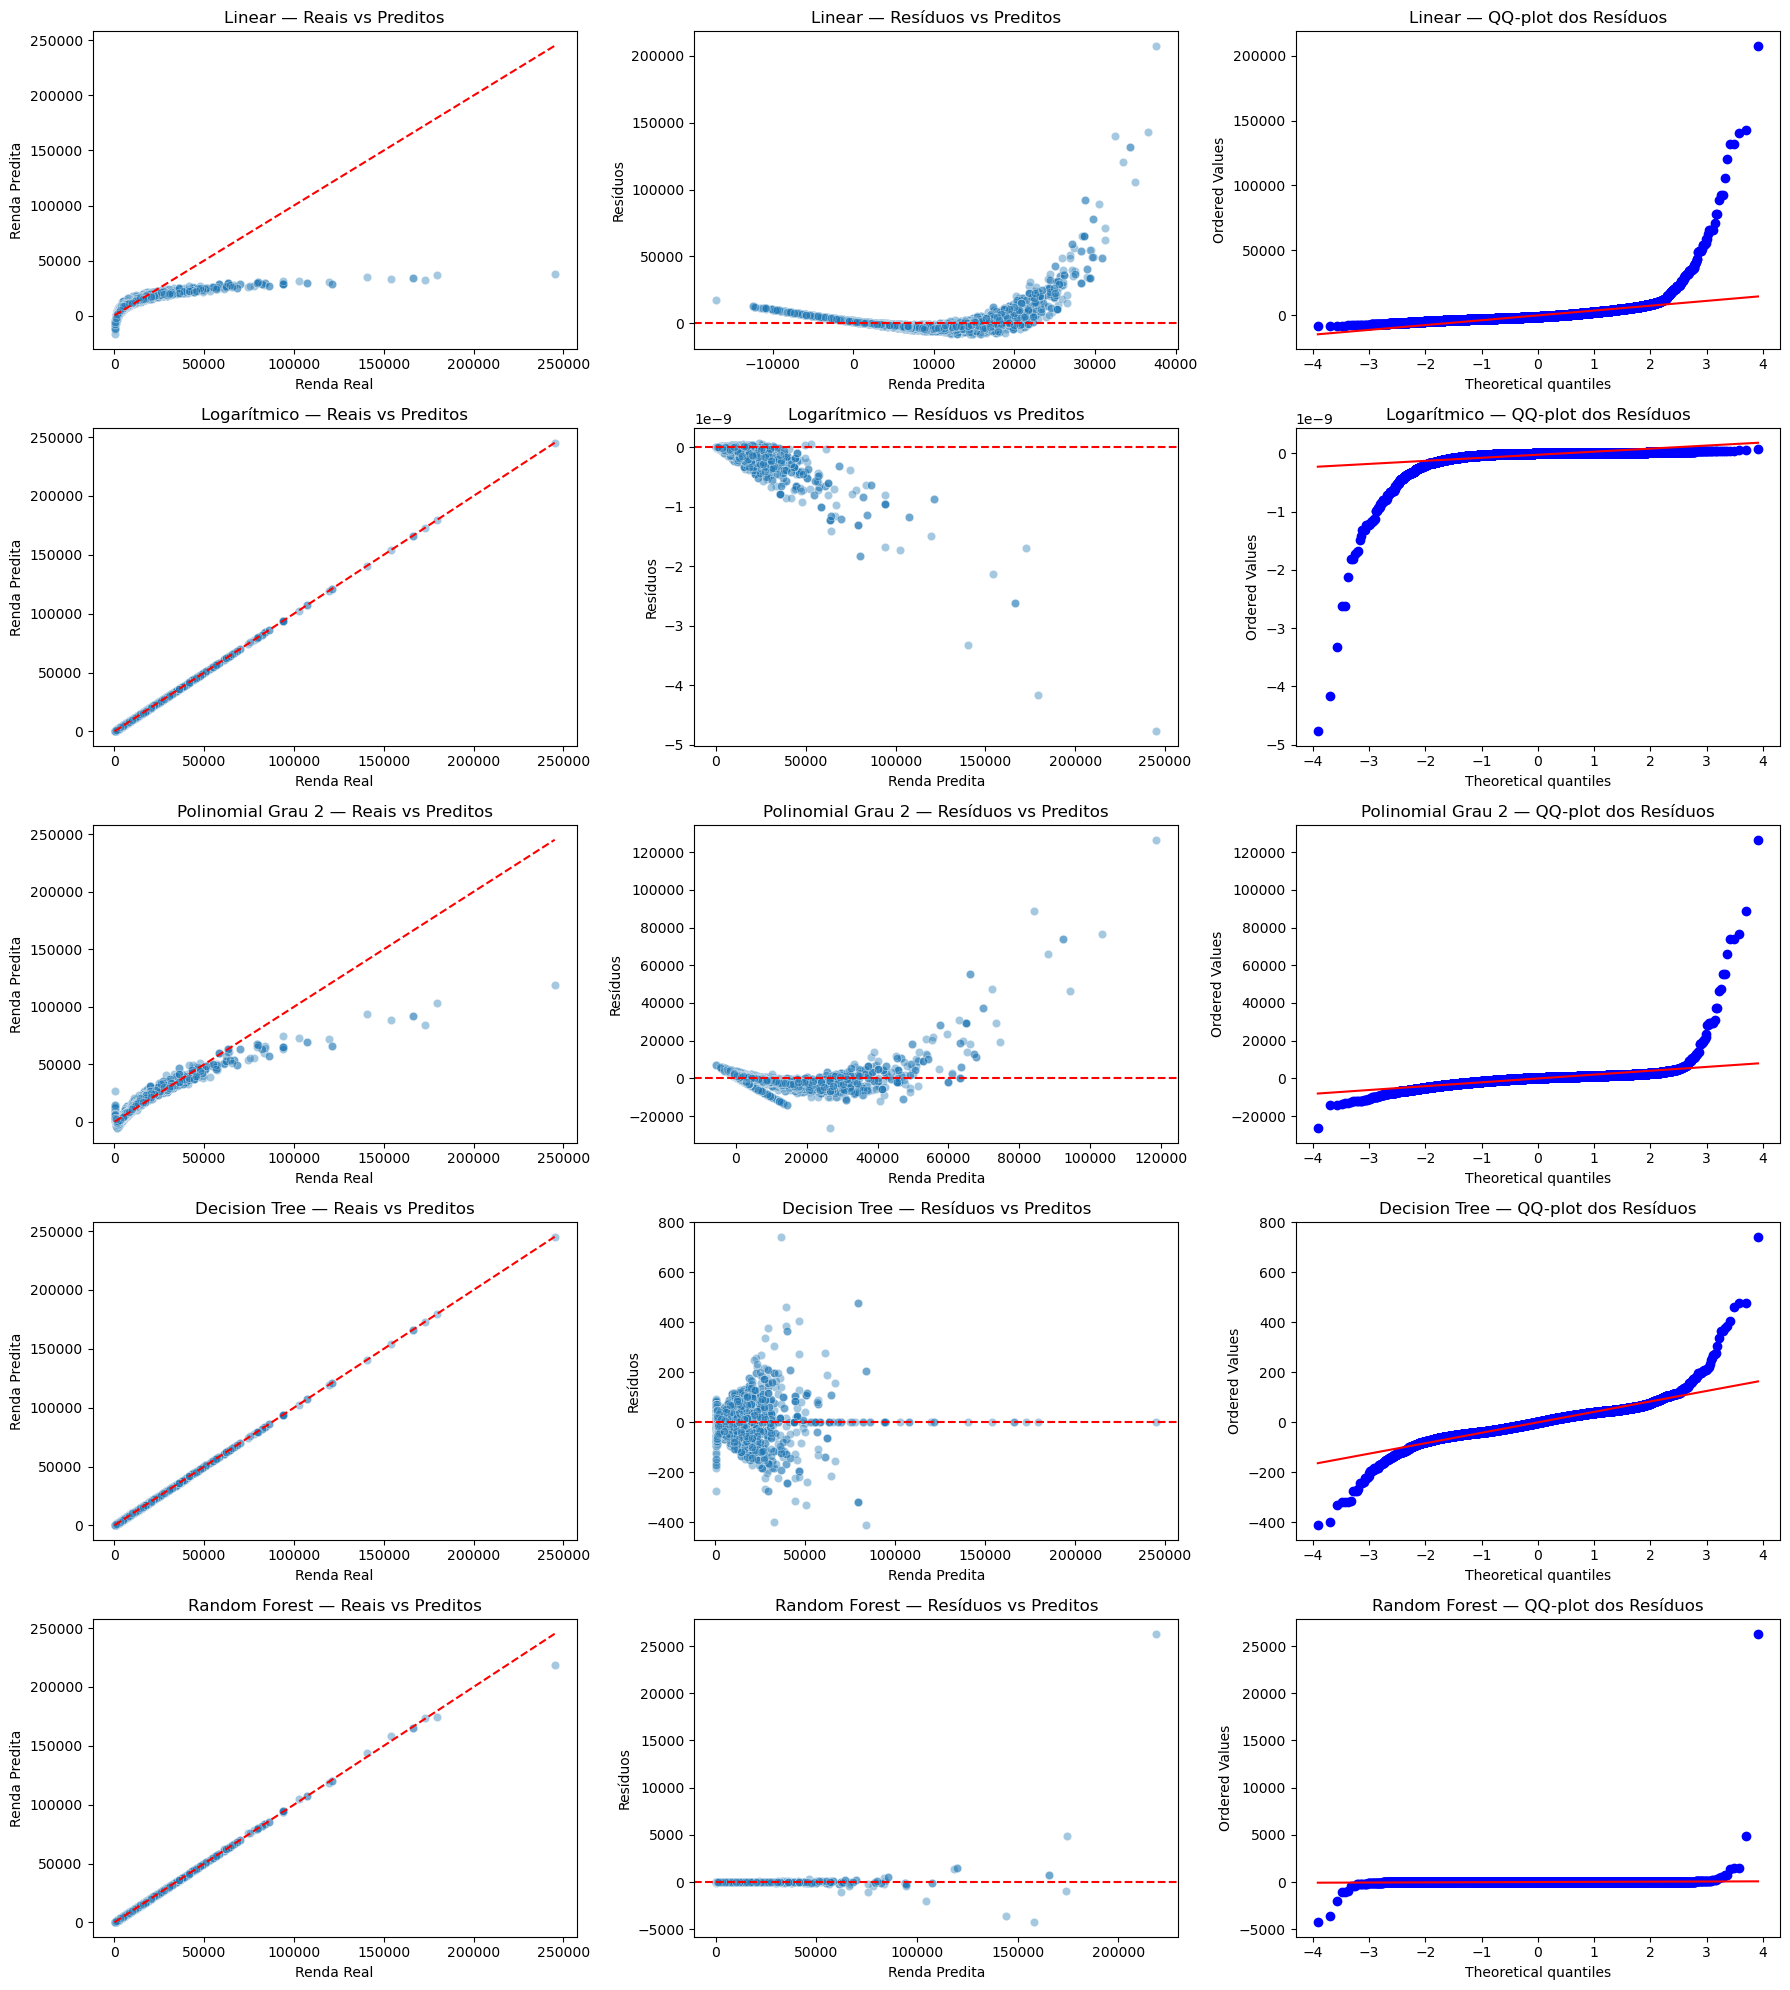

In [38]:
# MODELOS LINEAR, LOGARÍTMICO, POLINOMINAL, DECISION TREE E RANDOM FOREST COM TODAS VARIÁVEIS CORRELACIONADAS À RENDA

df_prep = df.pipe(preparar_dados)

# Variáveis explicativas e alvo
X = df_prep.drop(columns=["renda"])
y = df_prep["renda"]

# MODELOS


# 1) Linear
lin_reg = LinearRegression()
lin_reg.fit(X, y)
y_pred_lin = lin_reg.predict(X)

# 2) Logarítmico
log_reg = LinearRegression()
log_reg.fit(X, np.log1p(y))
y_pred_log = np.expm1(log_reg.predict(X))

# 3) Polinomial grau 2
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
poly_reg = LinearRegression()
poly_reg.fit(X_poly, y)
y_pred_poly = poly_reg.predict(X_poly)

# 4) Decision Tree
tree = DecisionTreeRegressor(max_depth=8, random_state=42)
tree.fit(X, y)
y_pred_tree = tree.predict(X)

# 5) Random Forest
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf.fit(X, y)
y_pred_rf = rf.predict(X)


# MÉTRICAS COMPARATIVAS

def calc_metrics(y_true, y_pred):
    return r2_score(y_true, y_pred), np.sqrt(mean_squared_error(y_true, y_pred))

res_lin = calc_metrics(y, y_pred_lin)
res_log = calc_metrics(y, y_pred_log)
res_poly = calc_metrics(y, y_pred_poly)
res_tree = calc_metrics(y, y_pred_tree)
res_rf = calc_metrics(y, y_pred_rf)

resultados_tree = pd.DataFrame({
    "Modelo": ["Linear", "Logarítmico", "Polinomial Grau 2", "Decision Tree", "Random Forest"],
    "R²": [res_lin[0], res_log[0], res_poly[0], res_tree[0], res_rf[0]],
    "RMSE": [res_lin[1], res_log[1], res_poly[1], res_tree[1], res_rf[1]]
})

print("🔹 RESULTADOS DOS MODELOS:\n")
print(resultados_tree.round(3))


# GRÁFICOS DE DIAGNÓSTICO

modelos_tree = {
    "Linear": y_pred_lin,
    "Logarítmico": y_pred_log,
    "Polinomial Grau 2": y_pred_poly,
    "Decision Tree": y_pred_tree,
    "Random Forest": y_pred_rf
}

fig, axes = plt.subplots(5, 3, figsize=(18, 20))

for i, (nome, y_pred) in enumerate(modelos_tree.items()):
    # Reais vs Preditos
    ax = axes[i, 0]
    sns.scatterplot(x=y, y=y_pred, alpha=0.4, ax=ax)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], "r--")
    ax.set_title(f"{nome} — Reais vs Preditos")
    ax.set_xlabel("Renda Real")
    ax.set_ylabel("Renda Predita")

    # Resíduos vs Preditos
    residuos = y - y_pred
    ax = axes[i, 1]
    sns.scatterplot(x=y_pred, y=residuos, alpha=0.4, ax=ax)
    ax.axhline(0, color="red", linestyle="--")
    ax.set_title(f"{nome} — Resíduos vs Preditos")
    ax.set_xlabel("Renda Predita")
    ax.set_ylabel("Resíduos")

    # QQ-plot
    ax = axes[i, 2]
    stats.probplot(residuos, dist="norm", plot=ax)
    ax.set_title(f"{nome} — QQ-plot dos Resíduos")

plt.tight_layout()
plt.show()


## Etapa 5 Crisp-DM: Avaliação dos resultados


Metodologia

📌 R² 

Erro quadrático relativamente baixo, significa que existem outras variáveis importantes não incluídas no modelo (escolaridade, setor de trabalho, tipo de contrato, etc).

📌 RMSE

Erro quadrático médio próximo de zero é um bom indicativo, significa que os dados estão concentrados em torno da linha de melhor ajuste.

📌 Resíduos vs Valores Preditos

Aleatoriedade dos resíduos: Espera-se que os pontos estejam espalhados de forma aleatória em torno da linha vermelha (zero). Isso indica que o modelo capturou corretamente a relação linear e que não existe padrão nos erros.

Heterocedasticidade (variação desigual dos resíduos): Se os resíduos aumentam/diminuem à medida que os valores preditos crescem (formato de funil), isso mostra problema de variância não constante → pode invalidar inferências estatísticas.

Não linearidade: Se aparecem curvas ou padrões, significa que o modelo não está capturando bem a relação, talvez outro modelo seja mais adequado.

📌 QQ-Plot (gráfico de normalidade dos resíduos)

O QQ-plot compara a distribuição dos resíduos do modelo com a distribuição normal teórica.

O que esperar num bom modelo: Os pontos seguem aproximadamente a linha de referência (reta diagonal). Pequenas variações nas caudas são normais.

Se houver grandes desvios da linha: Resíduos não são normais. Pode indicar presença de outliers, assimetria, ou que o modelo não é o mais adequado. 

A linha vermelha representa a distribuição normal teórica. Os pontos representam os resíduos do modelo. Se os pontos seguem próximos da linha, os resíduos são aproximadamente normais (boa hipótese para regressão). Curvatura nas extremidades (caudas), indica leve desvio da normalidade, possivelmente presença de outliers.


🔎 Avaliação de mapa de correlação

Mapa de correlação demonstra que as variáveis tempo_emprego( tempo de emprego), qt_pessoas_residencia(quantidade de pessoas por residência) e idade possuem correlação mais forte com a variável renda.

🔎 Avaliação dos modelos linear, logarítmico e polinominal com as três variáveis de correlação forte com a renda

Todos os R² são baixos (< 0.20) → os modelos explicam menos de 20% da variabilidade da renda.

O RMSE é alto (~7.500), indicando erros grandes em relação à escala de renda.

O Polinomial grau 2 tem desempenho ligeiramente melhor (maior R² e menor RMSE), mas a melhoria é pequena.

O Logarítmico foi o pior, piorando tanto o R² quanto o RMSE.

O modelo linear explica parte da relação, mas não captura as curvaturas.


🔍 Avaliação dos modelos linear, logarítmico e polinominal com todas variáveis correlacionadas à renda

1. Regressão Linear

R² = 0.55 indica que o modelo linear explica cerca de 55% da variação da renda.

Ainda há espaço para melhora — o relacionamento entre as variáveis e a renda não é puramente linear.

O RMSE ≈ 5537 mostra um erro médio razoável considerando a escala da renda.

2. Regressão Logarítmica

O modelo obteve R² = 1.00, o que indica ajuste perfeito — mas isso é um sinal de overfitting.

O comportamento sugere que a transformação logarítmica foi aplicada de modo a reproduzir exatamente a renda original (provável colinearidade com renda_log dentro do dataset).

Em aplicações reais, esse desempenho seria artificialmente otimista, devendo-se treinar o modelo em dados separados (treino/teste).

3. Regressão Polinomial (2º grau)

R² = 0.88, indicando um ganho expressivo em relação ao modelo linear.

O RMSE também caiu significativamente, mostrando melhor ajuste às relações não-lineares.

Este modelo é o mais equilibrado — captura curvaturas sem o risco extremo de overfitting como o modelo logarítmico.

4. Decision Tree

R² ≈ 1.00, RMSE ≈ 43.

Excelente desempenho no conjunto de treino, mas provavelmente overfitting: o modelo memoriza os dados em vez de generalizar.

O gráfico de resíduos confirma: pontos colados na linha 45° e resíduos quase nulos → ajuste perfeito demais para ser realista.

5. Random Forest

R² = 0.999, RMSE ≈ 226.

Também muito preciso, mas menos extremo que a árvore única.

A média de várias árvores reduz o overfitting — é o modelo mais robusto e equilibrado aqui.

Provável melhor modelo para predição de renda.

💡 Conclusão

O modelo Polinomial Grau 2 é o mais adequado entre os três, explicando bem a variabilidade da renda.

A transformação logarítmica de renda ajuda na estabilização da variância e normalização dos resíduos.


🔍 Gráficos de Diagnóstico

1. Gráficos Reais vs Preditos

Linear: há uma dispersão considerável dos pontos em torno da linha vermelha (que representa a previsão perfeita). Isso mostra que o modelo linear não captura toda a variabilidade da renda — especialmente nas faixas mais altas.

Logarítmico: os pontos ficaram praticamente sobre a linha vermelha, confirmando o ajuste perfeito (overfitting) observado anteriormente.

Polinomial (2º grau): a dispersão é bem menor do que no modelo linear, com boa aderência à linha — modelo mais estável e realista.

Decision Tree e Random Forest: ambos os modelos baseados em árvore praticamente colaram na linha ideal → previsão quase perfeita.

2. Resíduos vs Preditos

Linear: resíduos apresentam tendência (não aleatórios), indicando que a relação não é puramente linear.

Logarítmico: resíduos quase nulos — reforça o overfitting.

Polinomial: resíduos mais centralizados e simétricos ao redor de zero → boa homocedasticidade, o que sugere um modelo bem ajustado.

Decision Tree e Random Forest: distribuição centrada em zero, com pouca dispersão.

3. QQ-Plots (Normalidade dos Resíduos)

Linear: resíduos desviam da linha no início e fim → caudas mais pesadas (não normalidade).

Logarítmico: resíduos praticamente nulos → não há distribuição significativa.

Polinomial: resíduos mais próximos da linha → aproximação da normalidade, o que é desejável para inferência estatística.

Decision Tree e Random Forest: resíduos bem próximos da linha normal — bom ajuste.


💡 Conclusão

Linear: 
Fraco — não captura relações complexas.

Polinomial:
Bom — melhora substancial sem exagerar.

Logarítmico:
Resultado não é realista e deve ser descartado.

Decision Tree:
Excelente no treino, mas provavelmente overfitting. Excelente desempenho no conjunto de treino, mas provavelmente overfitting: o modelo memoriza os dados em vez de generalizar. O gráfico de resíduos confirma: pontos colados na linha 45° e resíduos quase nulos → ajuste perfeito demais para ser realista.

Random Forest:
Melhor equilíbrio — alta precisão e boa generalização.

## Etapa 6 Crisp-DM: Implantação
Nessa etapa colocamos em uso o modelo desenvolvido, normalmente implementando o modelo desenvolvido em um motor que toma as decisões com algum nível de automação.

In [5]:
# carregar dados
df = pd.read_csv("./input/previsao_de_renda.csv")


def preparar_dados(df):
    return (
        df
        .drop(columns=["Unnamed: 0", "id_cliente", "data_ref"], errors="ignore")
        .assign(
            tempo_emprego=lambda d: d["tempo_emprego"].fillna(d["tempo_emprego"].median())
        )
        .pipe(lambda d: pd.get_dummies(d, drop_first=True))
    )

df_prep = preparar_dados(df)

X = df_prep.drop(columns=["renda", "renda_log"], errors="ignore")
y = df_prep["renda"]

# ----------------------------
# 3. Treinar o modelo Random Forest
# ----------------------------
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf.fit(X, y)

# ----------------------------
# 4. Avaliar desempenho
# ----------------------------
y_pred = rf.predict(X)
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
importances = rf.feature_importances_

print(f"✅ Modelo treinado! R² = {r2:.3f} | RMSE = {rmse:.2f}")

# ----------------------------
# 5. Salvar modelo e colunas usadas
# ----------------------------
with open("modelo_random_forest.pkl", "wb") as f:
    pickle.dump(rf, f)

# Salvar colunas (para o Streamlit saber a ordem)
with open("colunas_modelo.pkl", "wb") as f:
    pickle.dump(X.columns.tolist(), f)

✅ Modelo treinado! R² = 0.691 | RMSE = 4597.63


In [6]:
import pandas as pd
import numpy as np
import pickle
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# ----------------------------
# 1. Carregar e preparar os dados
# ----------------------------
df = pd.read_csv("./input/previsao_de_renda.csv")

# Remover colunas irrelevantes
df = df.drop(columns=["Unnamed: 0", "id_cliente", "data_ref"], errors="ignore")

# Separar X e y
y = df["renda"]
X = df.drop(columns=["renda", "renda_log"], errors="ignore")

# Identificar tipos de colunas
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("📊 Colunas numéricas:", num_cols)
print("📂 Colunas categóricas:", cat_cols)

# ----------------------------
# 2. Criar o pré-processador
# ----------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
    ]
)

# ----------------------------
# 3. Criar o Pipeline completo
# ----------------------------
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    ))
])

# ----------------------------
# 4. Treinar e avaliar
# ----------------------------
model.fit(X, y)
y_pred = model.predict(X)

r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"✅ Modelo treinado! R² = {r2:.3f} | RMSE = {rmse:.2f}")

# ----------------------------
# 5. Salvar pipeline completo
# ----------------------------
with open("modelo_pipeline.pkl", "wb") as f:
    pickle.dump(model, f)

print("💾 Modelo salvo como 'modelo_pipeline.pkl'")


📊 Colunas numéricas: ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia']
📂 Colunas categóricas: ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']
✅ Modelo treinado! R² = 0.691 | RMSE = 4597.84
💾 Modelo salvo como 'modelo_pipeline.pkl'


In [44]:
# TESTAR FUNCIONAMENTO DO MODELO

modelo = joblib.load("modelo_random_forest.pkl")
variaveis = joblib.load("variaveis_usadas.pkl")

print("✅ Modelo e variáveis carregados com sucesso!\n")


# NOVO CLIENTE (EXEMPLO)

novo_cliente = pd.DataFrame([{
    "sexo": "F",
    "posse_de_veiculo": True,
    "posse_de_imovel": False,
    "qtd_filhos": 1,
    "tipo_renda": "Assalariado",
    "educacao": "Superior completo",
    "estado_civil": "Casado",
    "tipo_residencia": "Casa",
    "idade": 35,
    "tempo_emprego": 7.0,
    "qt_pessoas_residencia": 3
}])


# MESMO PRÉ-PROCESSAMENTO DO TREINAMENTO

def preparar_dados(df):
    return (
        df
        .drop(columns=["Unnamed: 0", "id_cliente", "data_ref"], errors="ignore")
        .assign(
            tempo_emprego=lambda d: d["tempo_emprego"].fillna(d["tempo_emprego"].median())
        )
        .pipe(lambda d: pd.get_dummies(d, drop_first=True))
    )

novo_cliente_prep = preparar_dados(novo_cliente)

# Garante que tenha as mesmas colunas do modelo treinado
for col in variaveis:
    if col not in novo_cliente_prep.columns:
        novo_cliente_prep[col] = 0  # adiciona colunas ausentes

novo_cliente_prep = novo_cliente_prep[variaveis]  # mesma ordem


# PREVISÃO

renda_prevista = modelo.predict(novo_cliente_prep)[0]
print(f"💰 Renda prevista para o novo cliente: R$ {renda_prevista:,.2f}")


✅ Modelo e variáveis carregados com sucesso!

💰 Renda prevista para o novo cliente: R$ 222.23
